In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from scipy.optimize import minimize_scalar
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from matplotlib import pyplot as plt

data = pd.read_csv('creditcard.csv')

dataset = data.to_numpy().astype(np.float32)

Plot a diagram for showing the imbalance between number of fraud and non-fraud transactions.

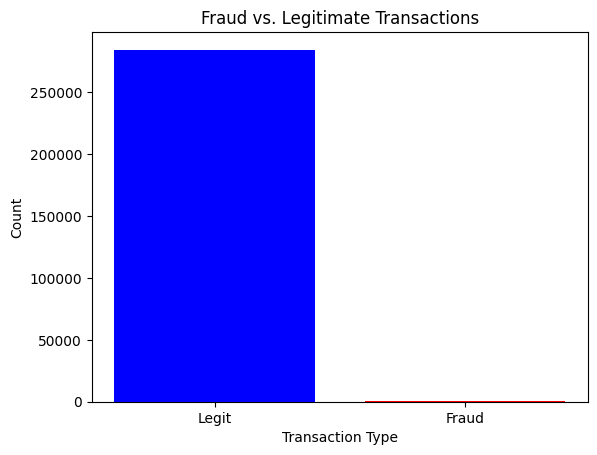

In [2]:
X, y = dataset[:, :-1], dataset[:, -1] 
fraud_count = np.bincount(y.astype(int))

plt.bar(["Legit", "Fraud"], fraud_count, color=["blue", "red"])
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.title("Fraud vs. Legitimate Transactions")
plt.show()

Perform PCA on the dataset and plot the projection of the transactions on the first two principal components.

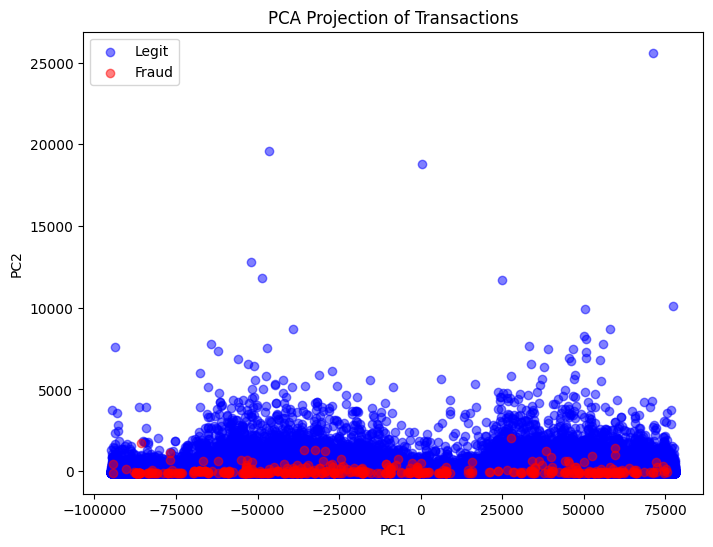

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X)
fraud_mask = dataset[:, -1] == 1

plt.figure(figsize=(8, 6))
plt.scatter(components[~fraud_mask, 0], components[~fraud_mask, 1], alpha=0.5, color="blue", label="Legit")
plt.scatter(components[fraud_mask, 0], components[fraud_mask, 1], alpha=0.5, color="red", label="Fraud")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("PCA Projection of Transactions")
plt.show()

In [4]:
scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), unit_variance=False)
dataset[:, [0, 29]] = scaler.fit_transform(dataset[:, [0, 29]])

X = dataset[:, :-1]
y = dataset[:, -1]

# Split the data into 70% training and 30% testing

In [5]:
data_train, data_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the Autoencoder model

In [6]:
# -----------------------------
# 3. Define the Autoencoder Model
# -----------------------------
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: 31 -> 23 -> 19 -> 17 -> 8 with dropout after first two hidden layers
        self.encoder = nn.Sequential(
            nn.Linear(30, 23),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(23, 19),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(19, 17),
            nn.Tanh(),
            nn.Linear(17, 8)
        )
        # Decoder: 8 -> 17 -> 19 -> 23 -> 31 with dropout after first two layers
        self.decoder = nn.Sequential(
            nn.Linear(8, 17),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(17, 19),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(19, 23),
            nn.Tanh(),
            nn.Linear(23, 30)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [7]:
# Get fraud and non-fraud data using y_train
fraud_indices = np.where(y_train == 1)[0]
non_fraud_indices = np.where(y_train == 0)[0]

fraud_data = data_train[fraud_indices]
non_fraud_data = data_train[non_fraud_indices]

# Calculate number of fraud samples for later use
n = len(fraud_data)
print(f"Number of fraud samples in training data: {n}")

# Select an equal number of non-fraud samples
non_fraud_data_limited = non_fraud_data[:n]

# Combine the selected data
X_balanced = np.vstack((non_fraud_data_limited, fraud_data))
y_balanced = np.hstack((np.zeros(n), np.ones(n)))  # Create labels: 0 for non-fraud, 1 for fraud

# Shuffle the data
shuffle_idx = np.random.permutation(len(X_balanced))
X_balanced_shuffled = X_balanced[shuffle_idx]
y_balanced_shuffled = y_balanced[shuffle_idx]

# Split into training and test sets for SVM
data_train_SVM, data_test_SVM, labels_train_SVM, labels_test_SVM = train_test_split(X_balanced_shuffled, y_balanced_shuffled, test_size=0.2, random_state=42)

# Train SVM model for validation in the oversampling process
model = SVC(kernel='linear', C=1.0)
model.fit(data_train_SVM, labels_train_SVM)

# Get predictions and accuracy
labels_pred_test = model.predict(data_test_SVM)
labels_pred_train = model.predict(data_train_SVM)
accuracy_train = np.mean(labels_pred_train == labels_train_SVM)
accuracy_test = np.mean(labels_pred_test == labels_test_SVM)

print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

Number of fraud samples in training data: 356
Train Accuracy: 0.9420
Test Accuracy: 0.9231


# Balanced the dataset

In [8]:
def get_fraud_indices(labels):
    """Return indices for which label == 1."""
    return np.where(labels == 1)[0]

def get_legit_indices(labels):
    """Return indices for which label == 0."""
    return np.where(labels == 0)[0]

# Example: placeholders for data_train, y_train
# data_train = np.random.randn(100, 30)
# y_train    = np.random.randint(0, 2, size=100)

# Make your copies to oversample
data_train_oversampled = data_train.copy()
labels_train_oversampled = y_train.copy()

# Load your pre-trained autoencoder
autoencoderModel = Autoencoder()
autoencoderModel.load_state_dict(
    torch.load("model/autoencoder/autoencoder30.pth", map_location=torch.device('cpu'))
)
autoencoderModel.eval()

alpha = 0.9

while len(get_fraud_indices(labels_train_oversampled)) < len(get_legit_indices(labels_train_oversampled)):
    fraud_indices = get_fraud_indices(labels_train_oversampled)

    # Check if we have fraud data to work with
    if len(fraud_indices) == 0:
        print("No fraud data found. Cannot proceed with oversampling.")
        break

    # 1) Gather all fraud samples (shape: (num_fraud, 30))
    fraud_only_X = data_train_oversampled[fraud_indices, :]
    fraud_data_tensor = torch.tensor(fraud_only_X, dtype=torch.float32)

    # 2) Encode to latent space
    latent_representations = autoencoderModel.encoder(fraud_data_tensor)
    n = len(latent_representations)
    if n == 0:
        print("Error: no latent representations. Check input data.")
        break

    # 3) Interpolate in latent space + add noise
    noisy_vectors = []
    for _ in range(300):
        i = np.random.randint(0, n)
        j = np.random.randint(0, n)

        z_i = latent_representations[i]
        z_j = latent_representations[j]

        lambda_ = np.random.rand()
        z_ij = lambda_ * z_i + (1 - lambda_) * z_j

        noise = torch.normal(mean=0.0, std=alpha, size=z_ij.shape)
        z_syn = z_ij + noise  # shape (8,)

        noisy_vectors.append(z_syn.detach().cpu().numpy())

    noisy_vectors = np.array(noisy_vectors)  # (300, 8)

    # 4) Decode them to original 30-dim space
    X_synthetic = autoencoderModel.decoder(
        torch.tensor(noisy_vectors, dtype=torch.float32)
    ).detach().cpu().numpy()  # shape (300, 30)

    # 5) Classify them with your SVM model
    #    "model" is your trained SVM that does model.predict(...)
    y_pred = model.predict(X_synthetic)  # shape (300,)

    # 6) Keep only predicted fraud
    synthetic_fraud_mask = (y_pred == 1)
    X_synthetic_fraud = X_synthetic[synthetic_fraud_mask]
    y_synthetic_fraud = y_pred[synthetic_fraud_mask]

    # 7) Append these new fraud samples to oversampled data
    data_train_oversampled = np.vstack((data_train_oversampled, X_synthetic_fraud))
    labels_train_oversampled = np.hstack((labels_train_oversampled, y_synthetic_fraud))

    n_fraud = len(get_fraud_indices(labels_train_oversampled))
    n_legit = len(get_legit_indices(labels_train_oversampled))
    print(f"New synthetic data generated: {len(X_synthetic_fraud)}")
    print(f"Number of fraud in the balanced dataset: {n_fraud} / {n_legit}")

print("Final shape of data:", data_train_oversampled.shape)
print("Final # Fraud:", len(get_fraud_indices(labels_train_oversampled)))
print("Final # Legit:", len(get_legit_indices(labels_train_oversampled)))

# # save the balanced data
# np.save("data_train_balanced.npy", data_train_oversampled)
# np.save("y_train_balanced.npy", labels_train_oversampled)


New synthetic data generated: 300
Number of fraud in the balanced dataset: 656 / 199008
New synthetic data generated: 299
Number of fraud in the balanced dataset: 955 / 199008
New synthetic data generated: 300
Number of fraud in the balanced dataset: 1255 / 199008
New synthetic data generated: 300
Number of fraud in the balanced dataset: 1555 / 199008
New synthetic data generated: 296
Number of fraud in the balanced dataset: 1851 / 199008
New synthetic data generated: 300
Number of fraud in the balanced dataset: 2151 / 199008
New synthetic data generated: 300
Number of fraud in the balanced dataset: 2451 / 199008
New synthetic data generated: 300
Number of fraud in the balanced dataset: 2751 / 199008
New synthetic data generated: 299
Number of fraud in the balanced dataset: 3050 / 199008
New synthetic data generated: 300
Number of fraud in the balanced dataset: 3350 / 199008
New synthetic data generated: 300
Number of fraud in the balanced dataset: 3650 / 199008
New synthetic data gene

# To speed up the development process, use the saved dataset

In [8]:
# load the balanced data
data_train_oversampled = np.load("data_train_balanced.npy")
labels_train_oversampled = np.load("y_train_balanced.npy")

# Train the ALSTM model

In [9]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = nn.Linear(hidden_size, 1, bias=False)
        
    def forward(self, lstm_output):
        # Check if we need to add a sequence dimension
        if len(lstm_output.shape) == 2:
            # Add a sequence dimension of length 1
            lstm_output = lstm_output.unsqueeze(1)
            
        # Now lstm_output should be (batch_size, seq_len, hidden_size)
        attention_scores = self.attention_weights(lstm_output)  # (batch_size, seq_len, 1)
        attention_scores = attention_scores.squeeze(-1)  # (batch_size, seq_len)
        
        # Apply softmax over sequence dimension
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, seq_len)
        
        # Apply attention weights
        context = torch.sum(lstm_output * attention_weights.unsqueeze(-1), dim=1)  # (batch_size, hidden_size)
        
        return context

class ALSTM(nn.Module):
    def __init__(self, input_size=30, hidden_size=10):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )

        self.attention = Attention(hidden_size)
        
        self.fc = nn.Linear(hidden_size, 1)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, (h, c) = self.lstm(x)
        
        # apply attention: 
        # (be sure your actual attention method expects lstm_out,h,c in that order)
        context = self.attention(lstm_out)
        
        # pass through linear layer
        logits = self.fc(context)
        
        # apply sigmoid
        out = self.sigmoid(logits)
        
        return out

In [ ]:
def train_model(model, X, y, num_epochs=100, batch_size=32, lr=0.001):
    # define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer

    # Convert numpy arrays to PyTorch tensors
    X_tensor_train = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y).reshape(-1, 1)  # Ensure proper shape

    if X_tensor_train.dim() == 2:
        X_tensor_train = X_tensor_train.unsqueeze(1)

    dataset = TensorDataset(X_tensor_train, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # train the model
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0

        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)

            # Compute loss - both should be batch_size x 1
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print progress
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}')

    return model

# Gradient Boosting Classifier

**Input:** Training set $T = \{(x_i, y_i)\}_{i=1}^m$, ALSTM as base learner, number of estimators $(n\_estimators)$

Initialize $h^0(x)$ with a constant: $h^0(x) = \arg \min \sum_{i=1}^n L(y_i, 0)$

**for** $t = 1, \ldots, n\_estimators$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Compute residuals: $r_i^t = -\frac{\partial L}{\partial h^{t-1}(x_i)}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Train $ALSTM_t(x)$ using the dataset $(x_i, r_i^t)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Calculate step length: $\alpha^t = \arg \min_\alpha \sum_{i=1}^n L(y_i, h^{t-1}(x_i) + \alpha h^t(x_i))$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Update the model: $h(x) = h(x) + \alpha^t h_t(x)$

**end for**

**Output:** Final ensemble model $h(x)$

Sì. Se la tua funzione di costo è

$$
L = \tfrac12 \sum_{i=1}^{n} \bigl(y_i - \hat{y}_i\bigr)^2,
$$

allora, quando vuoi scegliere **una costante** \(c\) che minimizzi la somma dei quadrati degli errori (senza dipendenza da $x$), il valore ottimale è la **media di $y$**:

$$
c^* \;=\; \arg\min_{c}\; \tfrac12 \sum_{i=1}^{n} (y_i - c)^2
\;=\;
\frac{1}{n} \sum_{i=1}^n y_i.
$$

Quindi, nel caso del Gradient Boosting con questa loss (che è sostanzialmente l’errore quadratico medio, a parte il fattore $\tfrac12$), **inizializzare $h^0(x)$ con la media di $y$ è corretto**.

In [ ]:
def GB_classifier(X, y, n_estimators=10):
    estimators = []

    loss_fn = lambda y, yhat: 1/2 * np.sum((y - yhat)**2)
    
    # hx = np.full(len(y), 0, dtype=np.float32)
    hx = np.full(len(y), np.mean(y), dtype=np.float32)

    for t in range(n_estimators):
        # compute the residual
        residuals = -(y - hx)

        model_t = ALSTM(input_size=30, hidden_size=10)
        
        # train model using the dataset (x_i, residuals_i)
        train_model(model_t, X, residuals, num_epochs=2)

        # predict the residuals
        model_t.eval()
        with torch.no_grad():
            # Convert input data to PyTorch tensor
            X_tensor = torch.FloatTensor(X)
            # Get model predictions
            predictions = model_t(X_tensor).cpu()
            # Convert predictions to numpy array
            h_t = predictions.numpy().flatten()
        
        func = lambda alpha: np.sum(loss_fn(y, hx + alpha * h_t))
        # compute step length
        # find the minimum scalar with bounds 0, 1
        alpha_t = np.float32(minimize_scalar(func, method = "golden").x)
        
        # update the predictions
        hx += alpha_t * h_t
        print(f"a_{t+1} = {alpha_t:.4f}")
        print(f"hx_{t+1} = {hx}")

        estimators.append((model_t, alpha_t))

    return estimators

In [ ]:
estimators = GB_classifier(data_train_oversampled, labels_train_oversampled, n_estimators=6)

RuntimeError: all elements of target should be between 0 and 1

In [ ]:
# evaluate the model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

hx = np.full(len(data_test), np.mean(labels_train_oversampled), dtype=np.float32)

# hx = np.zeros(len(data_test), dtype=np.float32)

# Go through each model in the trained ensemble
for model, alpha in estimators:
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(data_test)
        prediction = model(X_tensor).cpu().numpy().flatten()
    
    hx += alpha * prediction

y_pred_binary = np.where(hx > 0.5, 1, 0)

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

[2.8368775e-04 2.4022738e-05 4.3083844e-04 ... 2.4452747e-05 5.2934654e-05
 9.2257324e-05]
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy: 0.9984


In [80]:
# find the True Positives
TP = np.sum((y_test == 1) & (y_pred_binary == 1))
print(f"True Positives: {TP}")
# find False Positives
FP = np.sum((y_test == 0) & (y_pred_binary == 1))
print(f"False Positives: {FP}")
# find False Negatives
FN = np.sum((y_test == 1) & (y_pred_binary == 0))
print(f"False Negatives: {FN}")
# find True Negatives
TN = np.sum((y_test == 0) & (y_pred_binary == 0))
print(f"True Negatives: {TN}")

# calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy:.4f}")
# calculate the precision
precision = TP / (TP + FP)
print(f"Precision: {precision:.4f}")
# calculate the recall
recall = TP / (TP + FN)
print(f"Recall: {recall:.4f}")
# calculate the F1 score
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1:.4f}")

True Positives: 85
False Positives: 14
False Negatives: 51
True Negatives: 85293
Accuracy: 0.9992
Precision: 0.8586
Recall: 0.6250
F1 Score: 0.7234


In [68]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

final_model = estimators[-1][0]
precision = 0
recall = 0
f1 = 0
accuracy = 0
# Evaluate the final model
final_model.eval()
with torch.no_grad():
    # Convert input data to PyTorch tensor
    X_tensor = torch.FloatTensor(data_test)
    
    # If ALSTM expects 3D input, reshape to (batch, seq_len, features)
    if len(X_tensor.shape) == 2:
        X_tensor = X_tensor.unsqueeze(1)  # Adds sequence length dimension
        
    # Get model predictions
    predictions = final_model(X_tensor)
    # Convert predictions to numpy array
    y_pred = predictions.numpy().flatten()
    # Convert predictions to binary
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    accuracy = accuracy_score(y_test, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy: 0.9984


/Users/beatricezani/Desktop/pythonProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
